In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import utils

from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## 几个可视化函数

对于keras模型，离散分类预测要使用`predict_classes`。

`plot_confusion_matrix`不能用于keras模型，需要自己实现。使用`seaborn.heatmap`可以简单实现一个兼容版本。

In [2]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def plot_confusion_matrix_keras(model, x, y, display_labels=None, values_format='d', cmap='Blues'):
    classes = np.unique(y)
    if display_labels is None:
        display_labels = list(classes)
    d = []
    for cls in classes:
        predictions = model.predict_classes(x[y==cls])
        d.append([np.count_nonzero(predictions==subcls) for subcls in classes])
    d = np.asarray(d)
    sns.heatmap(
        d, cmap=cmap, fmt=values_format,
        annot=True, square=True, xticklabels=display_labels, yticklabels=display_labels
    )
    plt.xlabel('Predicted label')
    plt.ylabel('Truth label')

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict_classes(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict_classes(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix_keras(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict_classes(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict_classes(xvalid))

In [3]:
def plot_keras_history(history):
    plt.figure(figsize=(14, 7))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    plt.show()
    


## 载入数据及标签化处理

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [5]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [6]:
# we need to binarize the labels for the neural net
ytrain_enc = utils.to_categorical(ytrain)
yvalid_enc = utils.to_categorical(yvalid)

In [7]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

word_index = token.word_index
print(f'{len(word_index)} words tokenized')

25943 words tokenized


[861 594 445 377 335 270 256 191 190 186 186 168 164 157 150 149 148 148
 147 143]
[11097 13146  4671 15949 10402  4513 12550 13054  4673 16912  9212 12816
 13057   176 17020 15889 11323  7233  6910  2456]


e:\venvs\nlp\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


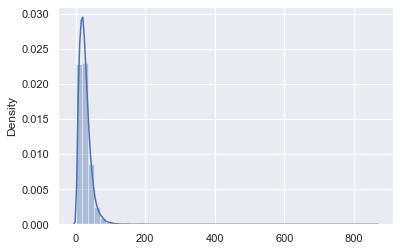

e:\venvs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


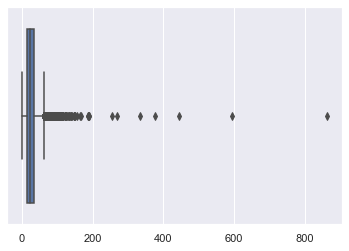

,sentence length
count,17621.000000
mean,26.679757
std,19.247341
min,2.000000
25%,15.000000
50%,23.000000
75%,34.000000
max,861.000000


In [8]:
sentence_len = np.array(list(map(len, xtrain_seq)))
print(-np.sort(-sentence_len)[:20])
print(np.argsort(-sentence_len)[:20])
sns.distplot(sentence_len)
plt.show()
sns.boxplot(sentence_len)
plt.show()
pd.DataFrame(sentence_len, columns=['sentence length']).describe()

In [9]:
max_len = 70

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)


In [10]:
print('original text:\n  ', xtrain[0], '\n')
print('sequence features:\n  ', xtrain_seq[0], '\n')
print('padded seq features:\n  ', xtrain_pad[0], '\n')
print('words:\n  ', [token.index_word.get(x, '___') for x in xtrain_pad[0]], '\n')

original text:
   Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head. 

sequence features:
   [29, 560, 8, 1, 5924, 459, 714, 3, 987, 1, 1794, 2, 29, 3695, 98, 4, 326, 5, 2545, 2, 3103, 27, 29, 166] 

padded seq features:
   [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   29  560    8    1 5924  459  714    3  987    1
 1794    2   29 3695   98    4  326    5 2545    2 3103   27   29  166] 

words:
   ['___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', 'her'

In [11]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)

# create an embedding matrix for the words we have in the dataset
embedding_width = len(embeddings_index['the'])
embedding_matrix = np.zeros((len(word_index) + 1, embedding_width))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('shape of train matrix:', xtrain_pad.shape)
print('shape of embedding matrix:', embedding_matrix.shape)

  0%|          | 0/25943 [00:00<?, ?it/s]

shape of train matrix: (17621, 70)
shape of embedding matrix: (25944, 300)


In [12]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(
    Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
)
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
35/35 [==============================] - 31s 803ms/step - loss: 1.0981 - categorical_accuracy: 0.3902 - val_loss: 0.9060 - val_categorical_accuracy: 0.5843
Epoch 2/100
35/35 [==============================] - 27s 774ms/step - loss: 0.9209 - categorical_accuracy: 0.5702 - val_loss: 0.7786 - val_categorical_accuracy: 0.6823
Epoch 3/100
35/35 [==============================] - 28s 789ms/step - loss: 0.8338 - categorical_accuracy: 0.6367 - val_loss: 0.7416 - val_categorical_accuracy: 0.7079
Epoch 4/100
35/35 [==============================] - 27s 781ms/step - loss: 0.7944 - categorical_accuracy: 0.6556 - val_loss: 0.7195 - val_categorical_accuracy: 0.7191
Epoch 5/100
35/35 [==============================] - 28s 801ms/step - loss: 0.7647 - categorical_accuracy: 0.6734 - val_loss: 0.7103 - val_categorical_accuracy: 0.7125
Epoch 6/100
35/35 [==============================] - 28s 810ms/step - loss: 0.7495 - categorical_accuracy: 0.6772 - val_loss: 0.6668 - val_categorical_accuracy:

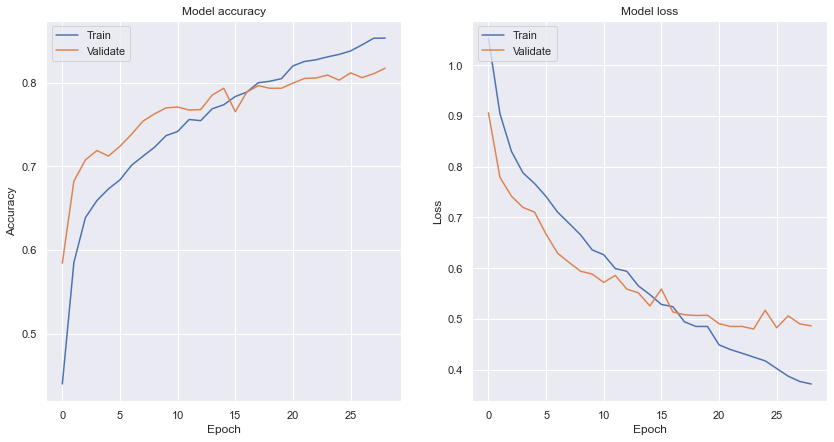

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           7783200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
gru (GRU)                    (None, 70, 300)           541800    
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense (Dense)                (None, 1024)              308224    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

In [13]:
plot_keras_history(model.history)
model.summary()

e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train set: logloss: 0.219


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


valid set: logloss: 0.486


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


train set
              precision    recall  f1-score   support

         EAP      0.898     0.949     0.923      7110
         HPL      0.968     0.902     0.934      5071
         MWS      0.938     0.929     0.933      5440

    accuracy                          0.929     17621
   macro avg      0.935     0.926     0.930     17621
weighted avg      0.931     0.929     0.929     17621

----------------------------------------------------------------------


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


validate set
              precision    recall  f1-score   support

         EAP      0.802     0.847     0.824       790
         HPL      0.857     0.798     0.826       564
         MWS      0.805     0.798     0.801       604

    accuracy                          0.818      1958
   macro avg      0.821     0.814     0.817      1958
weighted avg      0.819     0.818     0.818      1958



e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` las

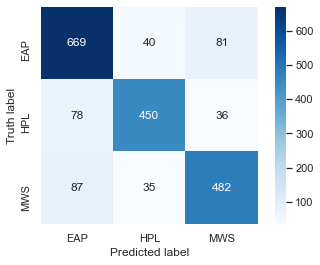

In [14]:
evaluate_model(model, 'GRU', xtrain_pad, ytrain, xvalid_pad, yvalid, fit=False)

In [15]:
# GRU with glove embeddings and two dense layers
alpha = 0.0005
L2 = regularizers.l2

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
# model.add(SpatialDropout1D(0.3))
model.add(GRU(
    300, dropout=0.3,
    recurrent_dropout=0.3, return_sequences=True,
    kernel_regularizer=L2(alpha), recurrent_regularizer=L2(alpha), bias_regularizer=L2(alpha),))
model.add(GRU(
    300, dropout=0.3,
    recurrent_dropout=0.3, kernel_regularizer=L2(alpha),
    recurrent_regularizer=L2(alpha), bias_regularizer=L2(alpha)))

model.add(Dense(1024, activation='relu', kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Dropout(0.8))

model.add(Dense(3, kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
35/35 [==============================] - 31s 797ms/step - loss: 2.3864 - categorical_accuracy: 0.4227 - val_loss: 1.7891 - val_categorical_accuracy: 0.5981
Epoch 2/100
35/35 [==============================] - 27s 775ms/step - loss: 1.6858 - categorical_accuracy: 0.6234 - val_loss: 1.4052 - val_categorical_accuracy: 0.7053
Epoch 3/100
35/35 [==============================] - 27s 779ms/step - loss: 1.4244 - categorical_accuracy: 0.6706 - val_loss: 1.2676 - val_categorical_accuracy: 0.7033
Epoch 4/100
35/35 [==============================] - 28s 794ms/step - loss: 1.2523 - categorical_accuracy: 0.7012 - val_loss: 1.1363 - val_categorical_accuracy: 0.7329
Epoch 5/100
35/35 [==============================] - 27s 780ms/step - loss: 1.1525 - categorical_accuracy: 0.7063 - val_loss: 1.0606 - val_categorical_accuracy: 0.7329
Epoch 6/100
35/35 [==============================] - 27s 778ms/step - loss: 1.0729 - categorical_accuracy: 0.7257 - val_loss: 1.0038 - val_categorical_accuracy:

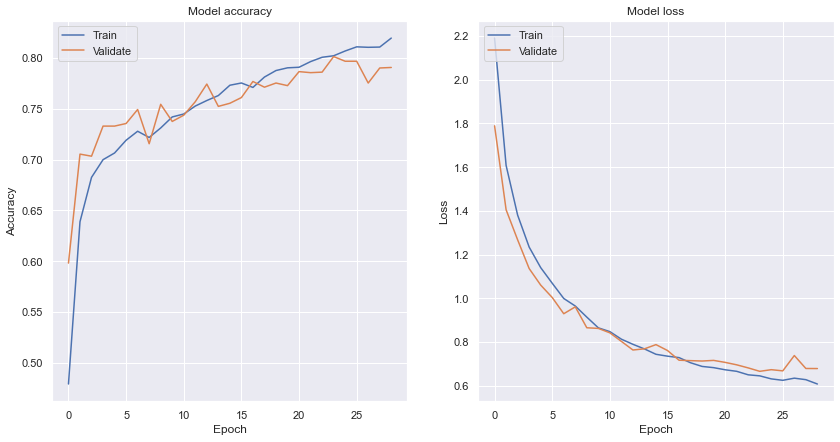

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           7783200   
_________________________________________________________________
gru_2 (GRU)                  (None, 70, 300)           541800    
_________________________________________________________________
gru_3 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

In [16]:
plot_keras_history(model.history)
model.summary()

e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train set: logloss: 0.343


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


valid set: logloss: 0.522


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


train set
              precision    recall  f1-score   support

         EAP      0.878     0.840     0.858      7110
         HPL      0.869     0.886     0.877      5071
         MWS      0.854     0.885     0.869      5440

    accuracy                          0.867     17621
   macro avg      0.867     0.871     0.868     17621
weighted avg      0.868     0.867     0.867     17621

----------------------------------------------------------------------


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


validate set
              precision    recall  f1-score   support

         EAP      0.814     0.766     0.789       790
         HPL      0.783     0.814     0.798       564
         MWS      0.769     0.801     0.785       604

    accuracy                          0.791      1958
   macro avg      0.789     0.794     0.791      1958
weighted avg      0.792     0.791     0.791      1958



e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` las

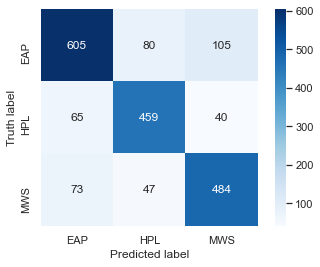

In [17]:
evaluate_model(model, 'GRU + L2(alpha=%d)' % (alpha, ), xtrain_pad, ytrain, xvalid_pad, yvalid, fit=False)

In [18]:
history

train            validate          
                   logloss  accuracy   logloss  accuracy
GRU                0.21944  0.926472  0.486165  0.814240
GRU + L2(alpha=0)  0.34258  0.870593  0.522187  0.793659

In [20]:
history['validate'] - history['train']

,logloss,accuracy
GRU,0.266725,-0.112232
GRU + L2(alpha=0),0.179607,-0.076934
